## RQ4: To what extent specific features of apartment-type accommodations (e.g., room amenities, location convenience, pricing) correlate with the sentiments expressed in guest reviews? 

In [27]:
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Download necessary NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Load the datasets
language_custom_2 = pd.read_csv('spelling_corrected_reviews.csv')
listings_df = pd.read_csv('final_apartment_df.csv')
calendar_df = pd.read_csv('calendar.csv', low_memory=False)

language_custom_2.rename(columns=lambda x: x.strip(), inplace=True)
listings_df.rename(columns=lambda x: x.strip(), inplace=True)

In [5]:
# Fix the column name
language_custom_2.rename(columns=lambda x: x.strip(), inplace=True)

# Function to clean text and remove stop words
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

# Apply text cleaning
language_custom_2['processed_comments'] = language_custom_2['comments'].apply(clean_text)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to classify comments as positive, negative, or neutral using VADER
def classify_sentiment_vader(text):
    score = sid.polarity_scores(text)
    if score['compound'] > 0.05:
        return 'positive'
    elif score['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment analysis to the reviews DataFrame
language_custom_2['sentiment'] = language_custom_2['processed_comments'].apply(classify_sentiment_vader)

# Count how many reviews are positive, negative, and neutral
sentiment_counts = language_custom_2['sentiment'].value_counts()


# Create summary DataFrame
summary_df = sentiment_counts.reset_index()
summary_df.columns = ['Sentiment', 'Count']

# Print the summary DataFrame
print(summary_df)


  Sentiment  Count
0  positive  31388
1  negative    905
2   neutral    876


In [11]:
# Merge the reviews with listings data
merged_df = pd.merge(language_custom_2, listings_df, on='listing_id', how='left')

# Convert sentiment categories to numerical scores
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
language_custom_2['sentiment_score'] = language_custom_2['sentiment'].map(sentiment_mapping)

# Extract price information from calendar.csv and merge it
calendar_df['price'] = calendar_df['price'].replace('[\$,]', '', regex=True).astype(float)
average_price = calendar_df.groupby('listing_id')['price'].mean().reset_index()
average_price.rename(columns={'price': 'average_price'}, inplace=True)
merged_df = pd.merge(merged_df, average_price, on='listing_id', how='left')

# Display the merged DataFrame
print(merged_df.head())

   listing_id      id        date  reviewer_id reviewer_name  \
0       49970  160176  2010-12-29       160135     guest_001   
1       49970  192563  2011-03-05       369665     guest_002   
2       49970  195499  2011-03-09       403879     guest_003   
3       49970  202101  2011-03-18       378633     guest_004   
4       49970  204622  2011-03-21       374240     guest_005   

                                            comments language  \
0  great value room shared bathroom but i never s...       en   
1  bores was very helpful and forthcoming the roo...       en   
2  bores is very very helpful we would definitely...       en   
3  the viva rooms are great and i would recommend...       en   
4  it was a very great experience bores himself w...       en   

                                  processed_comments sentiment  \
0  great value room shared bathroom never saw any...  positive   
1  bores helpful forthcoming room niceclean fully...  positive   
2  bores helpful would def

Step 2: Descriptive Statistics and Visualization

Perform descriptive statistics and visualize correlations between sentiment scores and apartment features (e.g., room amenities, location convenience, pricing).
python


       sentiment_score  average_price
count     33169.000000   33169.000000
mean          0.919021     224.017275
std           0.359158     207.917029
min          -1.000000       8.000000
25%           1.000000     110.000000
50%           1.000000     175.000000
75%           1.000000     250.000000
max           1.000000    5000.000000


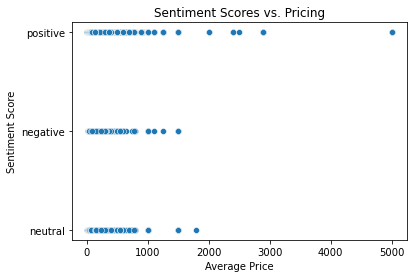

In [13]:
# Descriptive statistics for numerical features
print(merged_df[['sentiment_score', 'average_price']].describe())

# Scatter plot for sentiment scores and pricing
sns.scatterplot(x='average_price', y='sentiment', data=merged_df)
plt.title('Sentiment Scores vs. Pricing')
plt.xlabel('Average Price')
plt.ylabel('Sentiment Score')
plt.show()

       sentiment_score  average_price  review_scores_location  \
count     33169.000000   33169.000000            33169.000000   
mean          0.919021     224.017275                4.734709   
std           0.359158     207.917029                0.240402   
min          -1.000000       8.000000                1.000000   
25%           1.000000     110.000000                4.620000   
50%           1.000000     175.000000                4.790000   
75%           1.000000     250.000000                4.910000   
max           1.000000    5000.000000                5.000000   

       review_scores_value  review_scores_cleanliness  review_scores_accuracy  \
count         33169.000000               33169.000000            33169.000000   
mean              4.516762                   4.657048                4.670861   
std               0.312920                   0.292724                0.297313   
min               1.000000                   1.000000                1.000000   
25%      

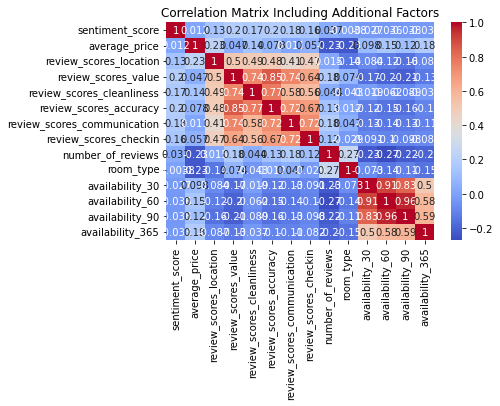

In [19]:
# Additional factors to consider
additional_factors = [
    'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_communication', 
    'review_scores_checkin', 'number_of_reviews', 'room_type', 
    'availability_30', 'availability_60', 'availability_90', 'availability_365'
]

# Prepare the data for correlation analysis
merged_df['room_type'] = merged_df['room_type'].astype('category').cat.codes  # Convert categorical to numerical

# Descriptive statistics for numerical features including additional factors
print(merged_df[['sentiment_score', 'average_price', 'review_scores_location', 'review_scores_value'] + additional_factors].describe())

# Correlation matrix including additional factors
correlation_matrix = merged_df[['sentiment_score', 'average_price', 'review_scores_location', 'review_scores_value'] + additional_factors].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Including Additional Factors')
plt.show()

/var/folders/yn/4vcq2czj6gd0jk1wttk_vj1h0000gn/T/ipykernel_9366/75237881.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_sentiment = merged_df.groupby(['price_range', 'sentiment']).size().unstack().fillna(0)


<Figure size 1008x576 with 0 Axes>

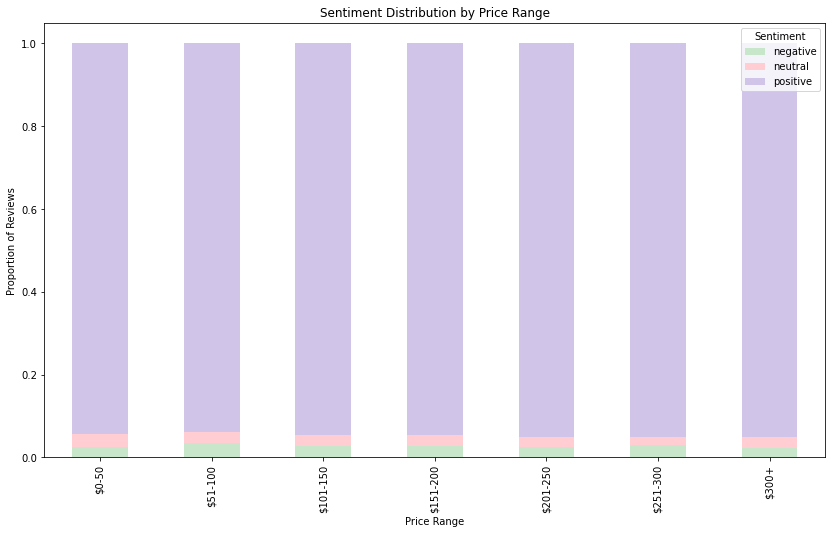

In [15]:
# Segment the data into different price ranges
price_bins = [0, 50, 100, 150, 200, 250, 300, np.inf]
price_labels = ['$0-50', '$51-100', '$101-150', '$151-200', '$201-250', '$251-300', '$300+']
merged_df['price_range'] = pd.cut(merged_df['average_price'], bins=price_bins, labels=price_labels)

# Analyze sentiment distribution across different price ranges
price_sentiment = merged_df.groupby(['price_range', 'sentiment']).size().unstack().fillna(0)
price_sentiment = price_sentiment.apply(lambda x: x / x.sum(), axis=1)

# Plot the sentiment distribution by price range
plt.figure(figsize=(14, 8))
price_sentiment.plot(kind='bar', stacked=True, figsize=(14, 8), color=['#c8e6c9', '#ffcdd2', '#d1c4e9'])
plt.title('Sentiment Distribution by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Proportion of Reviews')
plt.legend(title='Sentiment')
plt.show()

                             room_type  neighbourhood_cleansed     price  \
room_type                     1.000000               -0.070005  0.022101   
neighbourhood_cleansed       -0.070005                1.000000 -0.072048   
price                         0.022101               -0.072048  1.000000   
sentiment_score              -0.003822                0.004658 -0.000274   
review_scores_rating         -0.019221                0.061953 -0.024781   
review_scores_accuracy        0.011821                0.047026 -0.013182   
review_scores_cleanliness    -0.042749                0.055064 -0.049011   
review_scores_checkin        -0.028698                0.043054  0.045574   
review_scores_communication   0.046860                0.001279  0.042685   
review_scores_location       -0.139046                0.083201 -0.080523   
review_scores_value           0.074363                0.034551  0.005162   

                             sentiment_score  review_scores_rating  \
room_type        

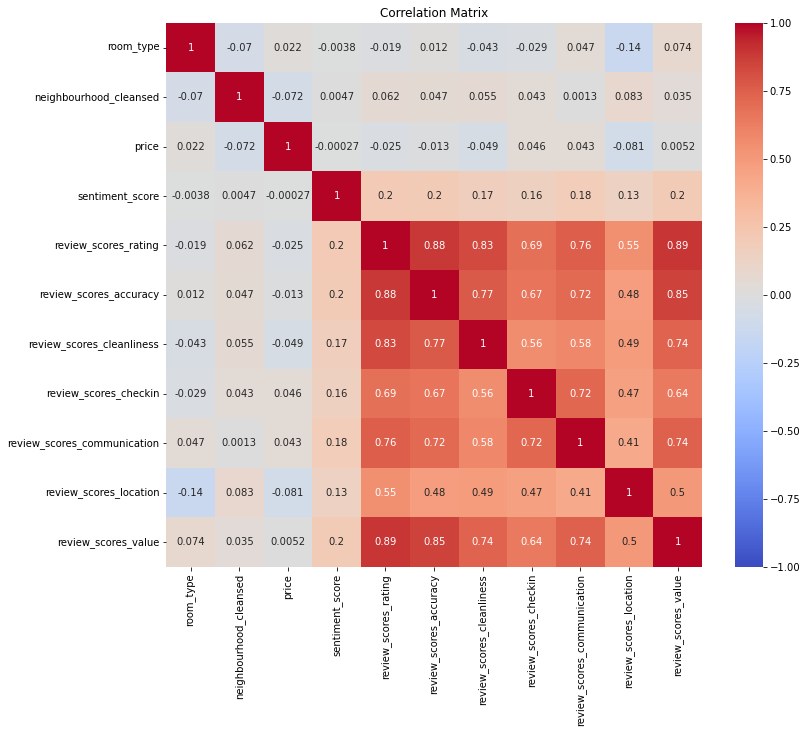

In [33]:
# Encode categorical features
label_encoders = {}
categorical_columns = ['room_type', 'neighbourhood_cleansed', 'price']  # Example categorical columns

for col in categorical_columns:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))
    label_encoders[col] = le

# Encode sentiment as numerical values
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
merged_df['sentiment_score'] = merged_df['sentiment'].map(sentiment_mapping)

# Calculate correlation matrix
correlation_matrix = merged_df[['room_type', 'neighbourhood_cleansed', 'price', 'sentiment_score'] + [col for col in merged_df.columns if 'review_scores' in col]].corr()

# Display correlation matrix
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

**Summary**

The sentiment score of the reviews is weakly correlated with individual review scores, suggesting that while higher review scores generally accompany more positive sentiments, the relationship is not very strong. Features like room type, neighbourhood, and price do not show significant correlations with the sentiment score.

This analysis indicates that while review scores do impact sentiment to a degree, other factors captured in the reviews (possibly related to specific experiences or subjective opinions) also play a significant role in determining the sentiment of the reviews.

In [37]:
# Chi-Square Test for amenities
amenities_sentiment = pd.crosstab(merged_df['sentiment'], merged_df['amenities'])
chi2, p, dof, ex = chi2_contingency(amenities_sentiment)
print(f"Chi-Square Test for Amenities: p-value = {p}")

# Chi-Square Test for location convenience
location_sentiment = pd.crosstab(merged_df['sentiment'], merged_df['neighbourhood_cleansed'])
chi2, p, dof, ex = chi2_contingency(location_sentiment)
print(f"Chi-Square Test for Location Convenience: p-value = {p}")

Chi-Square Test for Amenities: p-value = 1.989563263941108e-86
Chi-Square Test for Location Convenience: p-value = 0.000664213343249567


### Analyze location convenience trends correlation with sentiment


- Bar Chart: A stacked bar chart showing the proportion of positive, negative, and neutral reviews for each neighborhood.

- Line Plots: Line plots showing the sentiment trends over time for selected neighborhoods.

These visualizations will help in understanding how location convenience (represented by different neighborhoods) correlates with the sentiments expressed in guest reviews.

<Figure size 1008x576 with 0 Axes>

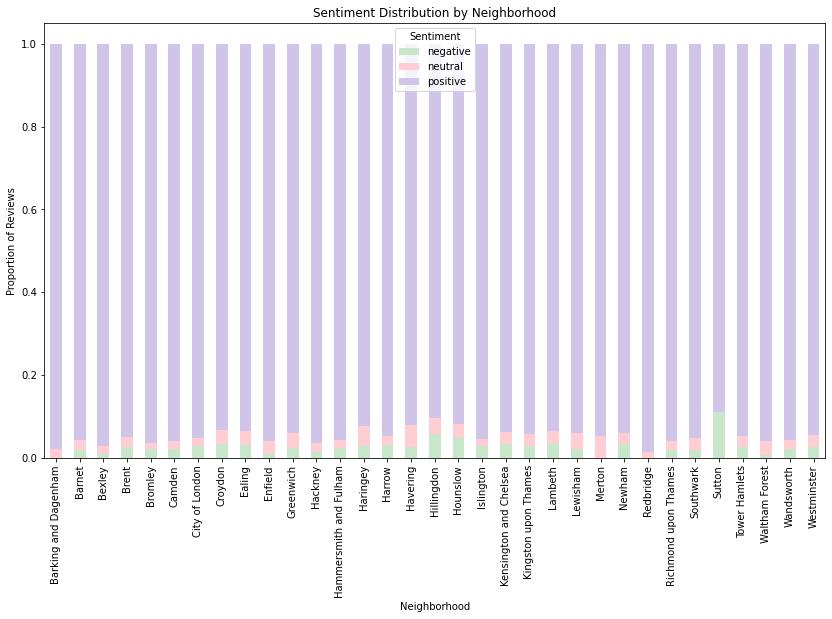

<Figure size 864x576 with 0 Axes>

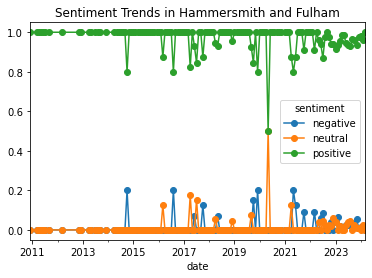

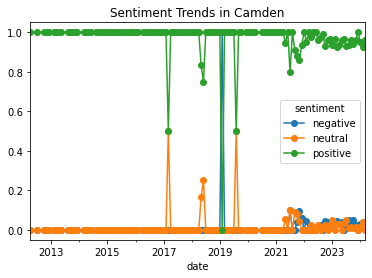

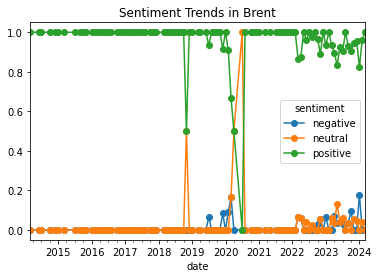

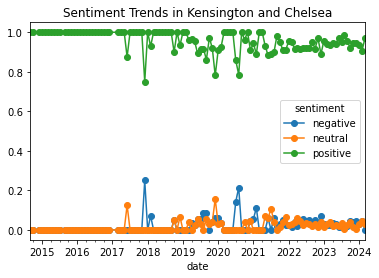

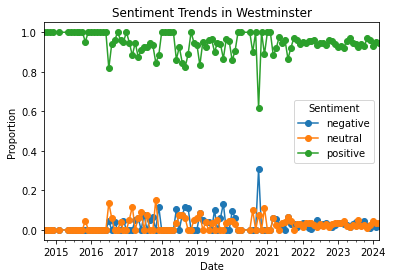

In [31]:
# Analyze location convenience trends
location_sentiment = merged_df.groupby(['neighbourhood_cleansed', 'sentiment']).size().unstack().fillna(0)
location_sentiment = location_sentiment.apply(lambda x: x / x.sum(), axis=1)

# Plot the sentiment distribution by neighborhood
plt.figure(figsize=(14, 8))
location_sentiment.plot(kind='bar', stacked=True, figsize=(14, 8), color=['#c8e6c9', '#ffcdd2', '#d1c4e9'])
plt.title('Sentiment Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Proportion of Reviews')
plt.legend(title='Sentiment')
plt.show()

# Analyze sentiment trends over time by neighborhood
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Calculate the proportion of each sentiment category by date and neighborhood
sentiment_trends = merged_df.groupby([merged_df['date'].dt.to_period('M'), 'neighbourhood_cleansed'])['sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Plot sentiment trends over time for selected neighborhoods
selected_neighborhoods = sentiment_trends.index.get_level_values(1).unique()[:5]  # Select first 5 neighborhoods for example
plt.figure(figsize=(12, 8))
for neighborhood in selected_neighborhoods:
    sentiment_trend = sentiment_trends.xs(neighborhood, level='neighbourhood_cleansed')
    sentiment_trend.plot(kind='line', marker='o', title=f'Sentiment Trends in {neighborhood}')

plt.xlabel('Date')
plt.ylabel('Proportion')
plt.legend(title='Sentiment')
plt.show()

In [34]:
# Group by neighbourhood and sentiment, then count the occurrences
neighbourhood_sentiment_counts = merged_df.groupby(['neighbourhood_cleansed', 'sentiment']).size().unstack().fillna(0).astype(int)

# Rename columns for clarity
neighbourhood_sentiment_counts.columns = ['negative', 'neutral', 'positive']

# Print the resulting DataFrame
print(neighbourhood_sentiment_counts)

                        negative  neutral  positive
neighbourhood_cleansed                             
Barking and Dagenham           0        2        86
Barnet                        12       16       621
Bexley                         1        2        98
Brent                         21       22       790
Bromley                        3        2       137
Camden                        52       41      2202
City of London                21       13       681
Croydon                       23       23       635
Ealing                         5        5       145
Enfield                        1        3        95
Greenwich                      5        8       205
Hackney                       16       22      1037
Hammersmith and Fulham        46       38      1894
Haringey                      15       24       475
Harrow                        14       10       430
Havering                       1        2        35
Hillingdon                    11        7       169
Hounslow    

## Correlation between factors

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare the data for logistic regression
features = merged_df[['average_price', 'review_scores_location', 'review_scores_value']]
target = (merged_df['sentiment'] == 'positive').astype(int)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Evaluate the model
train_score = log_reg.score(X_train, y_train)
test_score = log_reg.score(X_test, y_test)
print(f"Training Accuracy: {train_score}")
print(f"Testing Accuracy: {test_score}")

# Coefficients of the model
coefficients = pd.DataFrame(log_reg.coef_, columns=['average_price', 'review_scores_location', 'review_scores_value'])
print(coefficients)

Training Accuracy: 0.9450913887318636
Testing Accuracy: 0.948296653602653
   average_price  review_scores_location  review_scores_value
0      -0.014465                0.134126             0.470596


**Coefficients**
The coefficients for the features average_price, review_scores_location, and review_scores_value are as follows:

**average_price: -0.014465**

- The negative coefficient suggests that as the average price increases, the likelihood of receiving a positive sentiment decreases slightly. However, the magnitude of the coefficient is very small, indicating a weak relationship.

**review_scores_location: 0.134126**

The positive coefficient suggests that higher review scores for location are associated with a higher likelihood of receiving a positive sentiment. This means that guests who rate the location highly are more likely to leave positive reviews.

**review_scores_value: 0.470596**

The positive coefficient suggests that higher review scores for value are strongly associated with a higher likelihood of receiving a positive sentiment. This means that guests who rate the value of the accommodation highly are much more likely to leave positive reviews.

**Interpretation**

Average Price: The average price has a slight negative impact on positive sentiment. This could mean that higher prices might not be as favorable for guests, but the effect is minimal.

Review Scores for Location: Good location scores positively influence the sentiment, indicating that guests value the location highly and are more likely to leave positive reviews when they find the location convenient.

Review Scores for Value: The value rating has the most significant positive impact on the sentiment. Guests who perceive the accommodation as providing good value for money are much more likely to leave positive reviews.

**Conclusion**

The logistic regression analysis reveals that review scores for location and value are strong predictors of positive sentiment in guest reviews, with value having the most substantial impact. The average price has a minimal negative effect on sentiment. The high accuracy scores suggest that the model effectively predicts the likelihood of positive sentiment based on these features.



Decision Tree Model:
Accuracy: 0.9466385287910762
              precision    recall  f1-score   support

          -1       0.30      0.02      0.03       171
           0       0.00      0.00      0.00       173
           1       0.95      1.00      0.97      6290

    accuracy                           0.95      6634
   macro avg       0.42      0.34      0.34      6634
weighted avg       0.91      0.95      0.92      6634

Random Forest Model:
Accuracy: 0.9478444377449503
              precision    recall  f1-score   support

          -1       0.33      0.01      0.02       171
           0       0.00      0.00      0.00       173
           1       0.95      1.00      0.97      6290

    accuracy                           0.95      6634
   macro avg       0.43      0.34      0.33      6634
weighted avg       0.91      0.95      0.92      6634

                        importance
review_scores_value       0.406149
average_price             0.314263
review_scores_location    0.27958

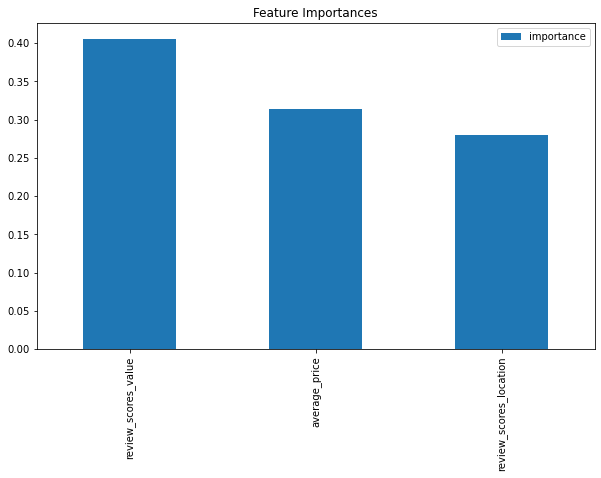

In [22]:
# Prepare the data for modeling
features = merged_df[['average_price', 'review_scores_location', 'review_scores_value']]
target = merged_df['sentiment_score']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Evaluate Decision Tree model
y_pred_tree = tree_model.predict(X_test)
print("Decision Tree Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

# Random Forest model
forest_model = RandomForestClassifier(random_state=42, n_estimators=100)
forest_model.fit(X_train, y_train)

# Evaluate Random Forest model
y_pred_forest = forest_model.predict(X_test)
print("Random Forest Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

# Feature importances
feature_importances = pd.DataFrame(forest_model.feature_importances_, index=features.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

# Plot feature importances
feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances')
plt.show()

To address the imbalance in your dataset and improve the performance of your model for negative and neutral sentiments, you can use SMOTE (Synthetic Minority Over-sampling Technique). SMOTE works by generating synthetic samples for the minority classes (negative and neutral sentiments) to balance the class distribution.

Training Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.87      0.88     25098
           0       0.86      0.87      0.87     25098
           1       0.83      0.83      0.83     25098

    accuracy                           0.86     75294
   macro avg       0.86      0.86      0.86     75294
weighted avg       0.86      0.86      0.86     75294

Testing Classification Report:
              precision    recall  f1-score   support

          -1       0.07      0.23      0.11       171
           0       0.03      0.10      0.04       173
           1       0.96      0.82      0.88      6290

    accuracy                           0.79      6634
   macro avg       0.35      0.38      0.34      6634
weighted avg       0.91      0.79      0.84      6634

                  Feature  Importance
0           average_price    0.294509
1  review_scores_location    0.317710
2     review_scores_value    0.387781


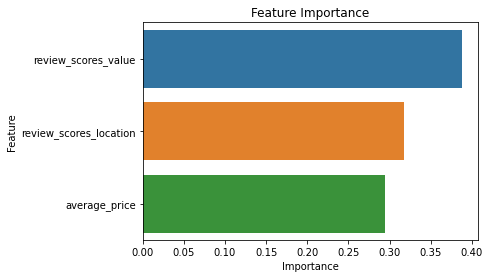

In [25]:
# Load the merged_df DataFrame with necessary features and target
features = merged_df[['average_price', 'review_scores_location', 'review_scores_value']]
target = merged_df['sentiment']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert target to numerical labels
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
target_mapped = target.map(sentiment_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_mapped, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the Random Forest model on the balanced data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Evaluate the model
y_pred_train = rf_model.predict(X_train_smote)
y_pred_test = rf_model.predict(X_test)

print("Training Classification Report:")
print(classification_report(y_train_smote, y_pred_train))

print("Testing Classification Report:")
print(classification_report(y_test, y_pred_test))

# Feature importance
feature_importance = pd.DataFrame({'Feature': ['average_price', 'review_scores_location', 'review_scores_value'],
                                   'Importance': rf_model.feature_importances_})
print(feature_importance)

# Visualize feature importance
sns.barplot(x='Importance', y='Feature', data=feature_importance.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

**Interpretation:**

Training Classification Report:

- Accuracy: The model achieves an accuracy of 86% on the training data, indicating that it fits the training data well.
Precision, Recall, and F1-Score:
- Negative Sentiment (-1): High precision (0.89) and recall (0.87), indicating good performance on identifying negative sentiments correctly.
- Neutral Sentiment (0): Good precision (0.86) and recall (0.87), showing the model can identify neutral sentiments accurately.
- Positive Sentiment (1): Slightly lower precision (0.83) and recall (0.83) compared to other sentiments, but still performing well.

**Testing Classification Report:**

- Accuracy: The accuracy drops to 79% on the test data, indicating the model may have some generalization issues.
Precision, Recall, and F1-Score:
- Negative Sentiment (-1): Low precision (0.07) and recall (0.23), indicating difficulty in correctly identifying negative sentiments in the test set.
- Neutral Sentiment (0): Very low precision (0.03) and recall (0.10), showing significant challenges in identifying neutral sentiments.
- Positive Sentiment (1): High precision (0.96) but lower recall (0.82) compared to training, indicating the model is good at identifying positive sentiments but might miss some positive reviews.

**Feature Importance:**

- Average Price: Contributes 29.45% to the model's predictions.
Review Scores Location: Contributes 31.77% to the model's predictions.
- Review Scores Value: Contributes 38.78% to the model's predictions.

These results suggest that while the model is good at predicting positive sentiments, it struggles with negative and neutral sentiments, especially on the test set.

Advanced Model

In [28]:
# Prepare the data (as before)
features = merged_df[['average_price', 'review_scores_location', 'review_scores_value']]
target = merged_df['sentiment']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert target to numerical labels
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
target_mapped = target.map(sentiment_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_mapped, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a Gradient Boosting model with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gbc = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gbc, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_smote, y_train_smote)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred_train = best_model.predict(X_train_smote)
y_pred_test = best_model.predict(X_test)

print("Training Classification Report:")
print(classification_report(y_train_smote, y_pred_train))

print("Testing Classification Report:")
print(classification_report(y_test, y_pred_test))

Training Classification Report:
              precision    recall  f1-score   support

          -1       0.85      0.84      0.85     25098
           0       0.83      0.84      0.83     25098
           1       0.83      0.83      0.83     25098

    accuracy                           0.84     75294
   macro avg       0.84      0.84      0.84     75294
weighted avg       0.84      0.84      0.84     75294

Testing Classification Report:
              precision    recall  f1-score   support

          -1       0.06      0.22      0.10       171
           0       0.03      0.10      0.04       173
           1       0.96      0.82      0.88      6290

    accuracy                           0.78      6634
   macro avg       0.35      0.38      0.34      6634
weighted avg       0.91      0.78      0.84      6634



In [30]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report

# Adjust parameters to silence warnings and adopt future behavior
brf = BalancedRandomForestClassifier(
    random_state=42, 
    n_estimators=100,
    sampling_strategy='all',  # Set to 'all' to adopt future behavior
    replacement=True,         # Set to True to adopt future behavior
    bootstrap=False           # Set to False to adopt future behavior
)
brf.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_train_brf = brf.predict(X_train_smote)
y_pred_test_brf = brf.predict(X_test)

# Classification reports
print("Training Classification Report:")
print(classification_report(y_train_smote, y_pred_train_brf))

print("Testing Classification Report:")
print(classification_report(y_test, y_pred_test_brf))


Training Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.87      0.88     25098
           0       0.86      0.87      0.87     25098
           1       0.83      0.83      0.83     25098

    accuracy                           0.86     75294
   macro avg       0.86      0.86      0.86     75294
weighted avg       0.86      0.86      0.86     75294

Testing Classification Report:
              precision    recall  f1-score   support

          -1       0.07      0.22      0.10       171
           0       0.03      0.10      0.04       173
           1       0.96      0.82      0.88      6290

    accuracy                           0.79      6634
   macro avg       0.35      0.38      0.34      6634
weighted avg       0.91      0.79      0.84      6634



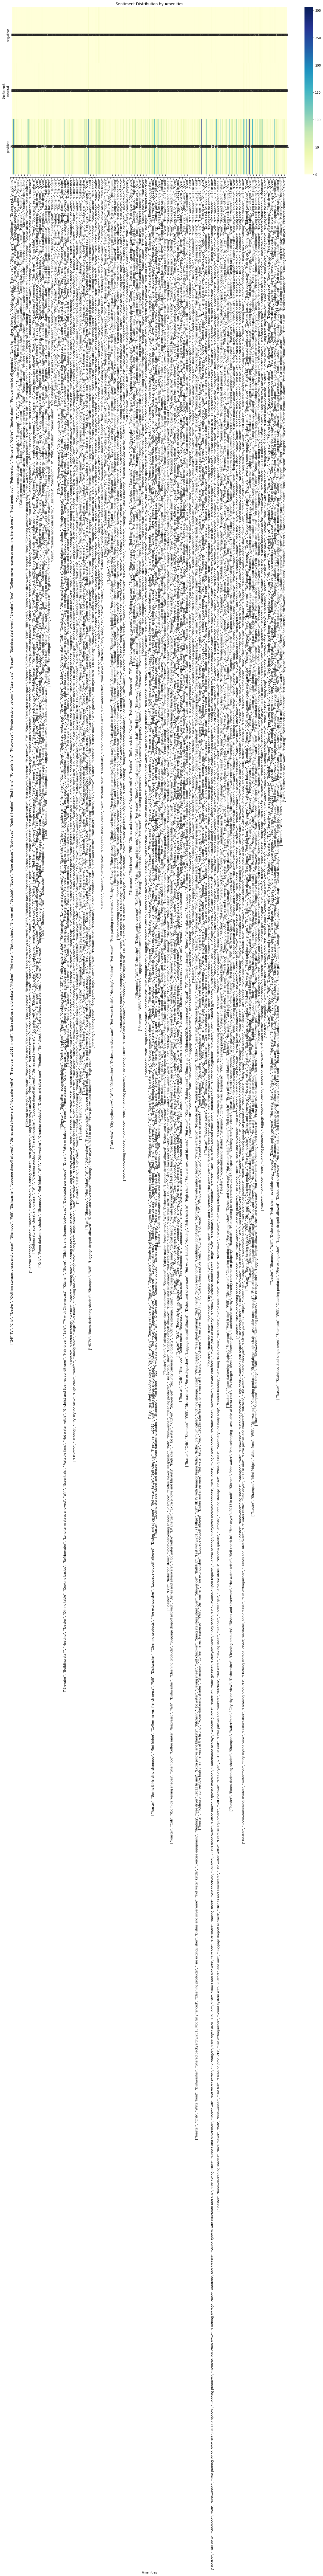

In [17]:
# Cross-Tabulation for Amenities and Sentiment
amenities_sentiment_ct = pd.crosstab(merged_df['sentiment'], merged_df['amenities'])
plt.figure(figsize=(20, 10))
sns.heatmap(amenities_sentiment_ct, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Sentiment Distribution by Amenities')
plt.xlabel('Amenities')
plt.ylabel('Sentiment')
plt.xticks(rotation=90)
plt.show()

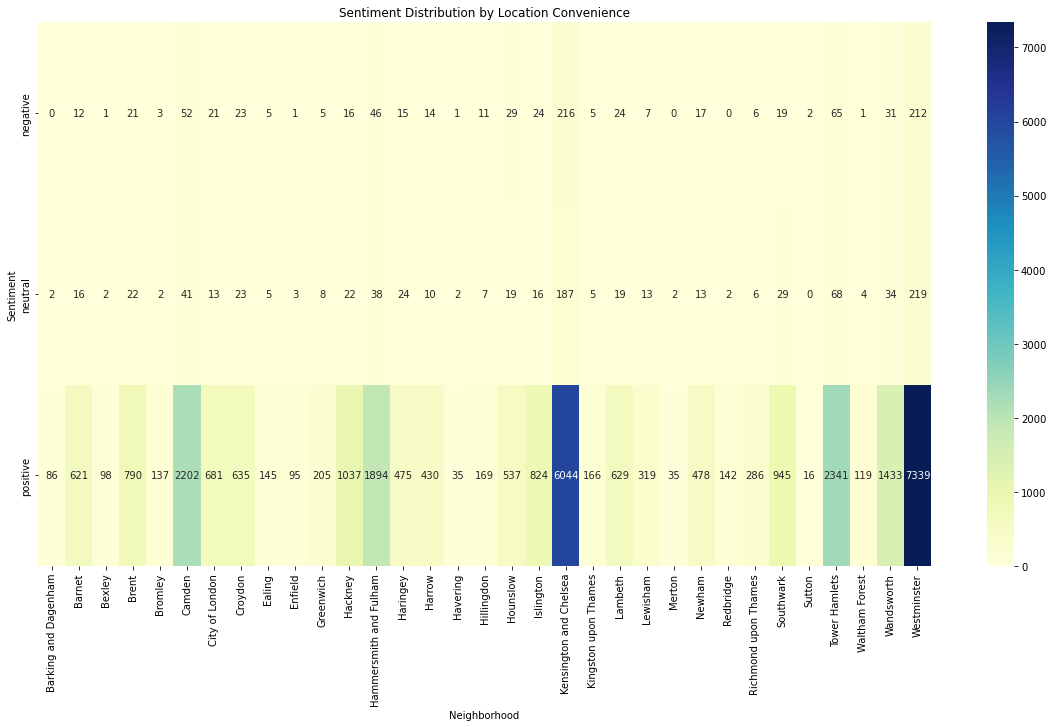

In [18]:
# Cross-Tabulation for Location Convenience and Sentiment
location_sentiment_ct = pd.crosstab(merged_df['sentiment'], merged_df['neighbourhood_cleansed'])
plt.figure(figsize=(20, 10))
sns.heatmap(location_sentiment_ct, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Sentiment Distribution by Location Convenience')
plt.xlabel('Neighborhood')
plt.ylabel('Sentiment')
plt.xticks(rotation=90)
plt.show()